In [93]:
import matplotlib.pyplot as plt
import ticktack
import numpy as np
import jax.numpy as jnp
from jax import jit
import jax

In [180]:
#     @partial(jax.jit, static_argnums=(0, 5, 6, 7, 8))
def production_rate_finder(cbm, data, time, oversample, steady_state_production, idx=0, prod=0.7, i=0):
        stead_state2 = steady_state_production * jnp.ones_like(time)
        time_values = jnp.linspace(jnp.min(time) - 1, jnp.max(time) + 1, (time.shape[0] + 1) * oversample)
        time_step = (time_values[1] - time_values[0])
        initial_production_fn = (lambda x: jnp.interp(x, time, stead_state2))
        initial_contents = _forward_pass(cbm, time, oversample, initial_production_fn, steady_state_production)
        # change index here for different data (str)
        initial_contents = jax.ops.index_update(initial_contents, jax.ops.index[:, 1], data)
        reverse_pass = _reverse_pass(cbm, initial_contents, time_step, prod, idx)
        new_production_fn = (lambda x: jnp.interp(x, time_values[1:], reverse_pass))
        new_contents = _forward_pass(cbm, time,oversample, new_production_fn, steady_state_production)
    
        for j in range(i):
            print(j)
            reverse_pass = _reverse_pass(cbm, new_contents, time_step, prod, idx)
            new_production_fn = (lambda x: jnp.interp(x, time_values[1:], reverse_pass))
            new_contents = _forward_pass(cbm, time,oversample, new_production_fn, steady_state_production)
    
        return new_contents, reverse_pass
    
def _reverse_pass(cbm, box_contents, time_step, production_coef=0.3, idx=1):
        difference = (box_contents[1:, :] - box_contents[0:-1, :]) / time_step
        production_terms = difference - jnp.transpose(jnp.matmul(cbm._matrix, jnp.transpose(box_contents)))[:-1, :]
        ans = jnp.transpose(jnp.matmul(cbm._matrix, jnp.transpose(box_contents)))[:-1, :]
        ans += production_terms
    
        production_terms /= production_coef
        # print(production_terms)
#         production_terms = jnp.where(production_terms < 0, 0, production_terms)
#         production_term = jnp.sum(production_terms, axis=1)
        production_term = production_terms[:, idx]
        return production_term
    
def _forward_pass(cbm, time, oversample, production_function, steady_state):
        new_box_contents, _ = cbm.run(time, oversample, production_function, steady_state_production=steady_state)
        return new_box_contents

In [ ]:
cbm = ticktack.load_presaved_model('Guttler14')
cbm.compile()


start = 760
resolution = 1000
burn_in_time = np.linspace(760 - 1000, 760, resolution)
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
burn_in_solutions = cbm.equilibrate(production_rate=steady_state_burn_in)
d_14_time_series_coarse = np.arange(760, 788)
d_14_time_series_fine = jnp.linspace(jnp.min(d_14_time_series_coarse) - 1, jnp.max(d_14_time_series_coarse) + 1, (d_14_time_series_coarse.shape[0] + 1) * 108)



In [ ]:
@jit 
def sg(t,start_time, duration, area):
    middle = start_time+duration/2.
    height = area/duration
    return height*jnp.exp(- ((t-middle)/(1./1.88349*duration))**8.)

@jit
def miyake_event(t, start_time, duration, phase, area):
#     height = jnp.where(((t > start_time) * (t < (start_time + duration))), area / duration, 0)
    height = sg(t, start_time, duration, area)
    prod =  steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

def sinCurve(t):
    return jnp.sin(t) + steady_state_burn_in

In [ ]:
burn_in, _ = cbm.run(burn_in_time, 108, production=sinCurve, y0=burn_in_solutions)
prod = sinCurve(d_14_time_series_fine)
event, _ = cbm.run(d_14_time_series_coarse, 108, production=sinCurve, y0=burn_in[-1, :])

In [181]:
box, reverse_pass = production_rate_finder(cbm, event[:,1], d_14_time_series_coarse, 108,steady_state_burn_in)

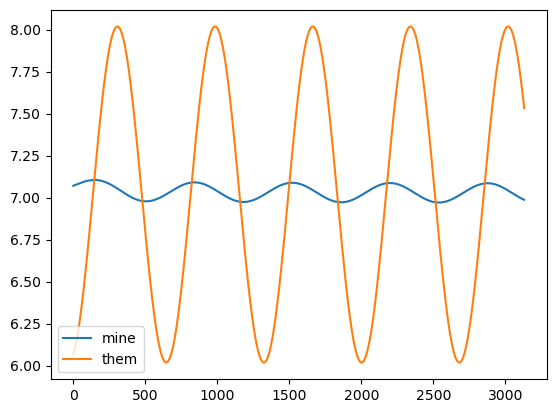

In [182]:
plt.plot(reverse_pass)
plt.plot(sinCurve(d_14_time_series_fine))
plt.legend(["mine", "them"])
#plt.plot(event[:,1])
plt.show()
